# SHAP 101 - explaining ml models and beyond

### Feature Attributions
* SHAP (SHapley Additive exPlanations) - https://shap.readthedocs.io/en/latest/
* Understand individual predictions - https://www.kaggle.com/code/dansbecker/shap-values/tutorial
* Aggregate SHAP values for even more detailed model insights - https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial
* Style SHAP Plots - https://towardsdatascience.com/how-to-easily-customize-shap-plots-in-python-fdff9c0483f2?gi=754319eae2c8

* Convert SHAP Score to percentage: https://medium.com/towards-data-science/* black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d

### Partial Dependence Plot
* Partial Dependence Plot Theory - https://christophm.github.io/interpretable-ml-book/pdp.html
* Partial Dependence Plots - https://scikit-learn.org/stable/modules/partial_dependence.html

### Additional References
* Fairlearn - https://fairlearn.org
* squaredev.io - https://github.com/squaredev-io/explainable-ai
* Rerun-sdk - https://pypi.org/project/rerun-sdk/

### Pandas 
* Working with missing value - https://pandas.pydata.org/docs/user_guide/missing_data.html
* show max columns - https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe/11711637#11711637
* DataFrame types with dtypes - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html

### Scikit-Learn
* Custom Demo Classifier _ https://scikit-learn.org/stable/developers/develop.html
* Custom Classification Model - https://towardsdatascience.com/how-to-create-custom-scikit-learn-classification-and-regression-models-70db7e76addd
* Custom ensemble Model - https://towardsdatascience.com/how-to-build-a-custom-estimator-for-scikit-learn-fddc0cb9e16e?gi=b6f190dcd368
* Custom Regression Model - https://towardsdatascience.com/building-a-custom-model-in-scikit-learn-b0da965a1299

### Model validation
Confusion Matrix, ROC, AUC - https://towardsdatascience.com/intuition-behind-roc-auc-score-1456439d1f30?gi=c4b96aa0c60e

# Kaggle Titanic Compitition
https://www.kaggle.com/competitions/titanic

### Data Description
https://www.kaggle.com/competitions/titanic/data?select=train.csv

| Variable | Definition	| Key | 
| :--- | :--- | :--- |
| survival | Survival |	0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
| sex |	Sex	| |
| Age |	Age | in years | 	
| sibsp	| # of siblings / spouses aboard the Titanic |	
| parch	| # of parents / children aboard the Titanic |	
| ticket |	Ticket number | |	
| fare | Passenger fare | (Y.W.: Ticket price paid)  |	
| cabin	| Cabin number | |	
| embarked	| Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

**pclass:** A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [63]:
%load_ext autoreload
%autoreload 2

# load JS visualization code to notebook
import shap
shap.initjs()

# graphic display modes
%matplotlib inline
#DARK_MODE = True
DARK_MODE = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from utils.datahelper import (
    KaggleData, 
    current_dir_subpath,
    profile, 
    feature_correlation, 
    na_columns,
    fill_missing_values_with_mean,
)

from utils.modelhelper import (
    ProbBinaryClassifier,
    ModelValidator,
    ModelExplainer,
    ModelKernelExplainer
)

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import DataFrame

# set the pandas display
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000) # for print

titanic_train_path = current_dir_subpath("data/train.csv")
titanic_test_path = current_dir_subpath("data/test.csv")
label_name = "Survived"
one_hot_cols = ["Sex"]

titanic = KaggleData(
     train_path = titanic_train_path,
     test_path = titanic_test_path,
     label_col=label_name
)

# load all raw unprocessed data as DataFrame, label as Series
# one_hot_cols transfers categorical column to one_hot encoded column 
train_X_raw_df, test_X_raw_df, train_raw_y = titanic.load(one_hot_cols=one_hot_cols)
all_X_raw_df = titanic.load_all(one_hot_cols=one_hot_cols)

## Explore numerical features in different data sets

In [65]:
# detect the numerical features for building classifier
num_features = all_X_raw_df.describe().columns.to_list()
print(num_features)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']


In [66]:
profile(train_X_raw_df, title="Profile of Raw Training Dataset")
print("\n" + "#" * 20)
profile(test_X_raw_df, title="Profile of Raw Test Dataset")

Profile of Raw Training Dataset
Shape: (891, 12)
Numerical Columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
Num. Columns ['Age'] has total no. of NaN : 177
       PassengerId      Pclass         Age       SibSp       Parch        Fare  Sex_female    Sex_male
count   891.000000  891.000000  714.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    2.308642   29.699118    0.523008    0.381594   32.204208    0.352413    0.647587
std     257.353842    0.836071   14.526497    1.102743    0.806057   49.693429    0.477990    0.477990
min       1.000000    1.000000    0.420000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     223.500000    2.000000   20.125000    0.000000    0.000000    7.910400    0.000000    0.000000
50%     446.000000    3.000000   28.000000    0.000000    0.000000   14.454200    0.000000    1.000000
75%     668.500000    3.000000   38.000000    1.000000    0.000000   31.000000

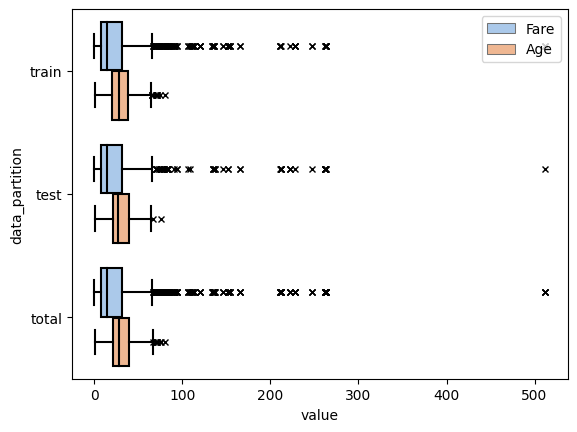

In [67]:
# titanic.boxplot_dist(["PassengerId", "Fare", "Age"], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)
titanic.boxplot_dist(["Fare", "Age"], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)

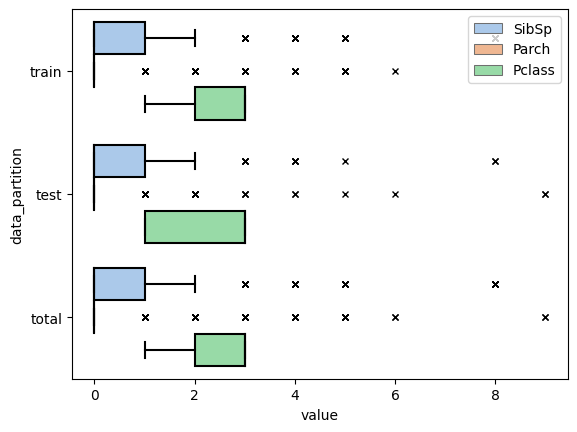

In [68]:
titanic.boxplot_dist(['Pclass', 'SibSp', 'Parch'], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)

## Data Inputation

replace the NaN values of numerical features in training and test dataset

In [69]:
# train_X_raw_df.describe()
# test_X_raw_df.describe()
# all_X_raw_df.describe()

In [70]:
def filter_values(x):
    """x is tuple with two positions"""
    match x[0]:
        case "Age":
            return (x[0], round(x[1]))
        case "Fare":
            return (x[0], round(x[1], 4)) # returns float with rounded 4 decimals
        case _:
            return x   

In [71]:
train_X_raw_df, train_mean_dict = fill_missing_values_with_mean(
    df=train_X_raw_df, pop_df=all_X_raw_df, filter_cols=num_features, filter_func=filter_values)
print(train_mean_dict)
print(f"no. of numerical cols. has NaN values: {len(na_columns(train_X_raw_df, num_features))}")

{'Age': 30}
no. of numerical cols. has NaN values: 0


In [72]:
test_X_raw_df, test_mean_dict = fill_missing_values_with_mean(
    df=test_X_raw_df, pop_df=all_X_raw_df, filter_cols=num_features, filter_func=filter_values)
print(test_mean_dict)
print(f"no. of numerical cols. has NaN values: {len(na_columns(test_X_raw_df, num_features))}")


{'Age': 30, 'Fare': 33.2955}
no. of numerical cols. has NaN values: 0


## Examining the correlation of numerical features and labels

In [73]:
train_X_y_raw_df = pd.concat([train_X_raw_df, train_raw_y], axis=1)
threshold = 0.2
corr_df, high_corr_df = feature_correlation(train_X_y_raw_df, label=label_name, threshold=threshold)
corr_df


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Survived
PassengerId,1.000000,-0.035144,0.033019,-0.057527,-0.001652,0.012658,-0.042939,0.042939,-0.005007
Pclass,-0.035144,1.000000,-0.329727,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.338481
Age,0.033019,-0.329727,1.000000,-0.232440,-0.180330,0.090632,-0.084660,0.084660,-0.070657
SibSp,-0.057527,0.083081,-0.232440,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.035322
Parch,-0.001652,0.018443,-0.180330,0.414838,1.000000,0.216225,0.245489,-0.245489,0.081629
Fare,0.012658,-0.549500,0.090632,0.159651,0.216225,1.000000,0.182333,-0.182333,0.257307
Sex_female,-0.042939,-0.131900,-0.084660,0.114631,0.245489,0.182333,1.000000,-1.000000,0.543351
Sex_male,0.042939,0.131900,0.084660,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.543351
Survived,-0.005007,-0.338481,-0.070657,-0.035322,0.081629,0.257307,0.543351,-0.543351,1.000000


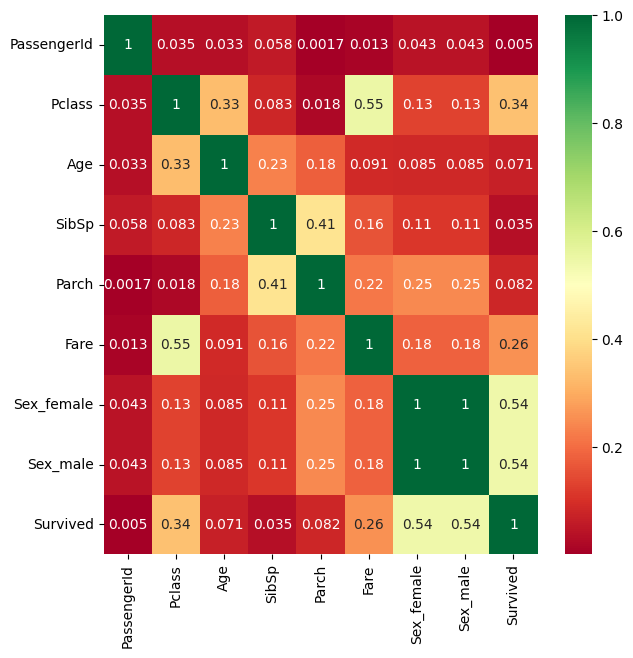

In [74]:
corr_df = corr_df.apply(abs)
plt.figure(figsize=(7,7))
map = sns.heatmap(corr_df,annot=True,cmap="RdYlGn")

In [75]:
# display the features with high correlation to the label
high_corr_df

,Survived
Pclass,-0.338481
Fare,0.257307
Sex_female,0.543351
Sex_male,-0.543351
Survived,1.000000


## Select features

In [76]:
# select only numerical features
selected_features = num_features.copy()
selected_features.remove("PassengerId")

In [77]:
# split the training data
X_train, X_valid, y_train, y_valid = titanic.split(
    titanic.select_cols(df=train_X_raw_df, cols=selected_features), 
    train_raw_y, test_size=0.2, random_state=10)

## Model: naiv gender based

In [78]:
X_y_train = pd.concat([X_train, y_train], axis=1)

# women = train_X_y_raw_df.loc[train_X_y_raw_df["Sex_female"] == 1]["Survived"]
# rate_women = sum(women) / len(women)

def survived_rate(df: DataFrame, feature_name="Sex_female", feature_value=1, label_name="Survived"):
    label_part = df.loc[df[feature_name] == feature_value][label_name]
    return sum(label_part) / len(label_part)

rate_women = survived_rate(X_y_train, "Sex_female")
print(f"% of women who survied: {rate_women:.2%}")

rate_men = survived_rate(X_y_train, "Sex_male")
print(f"% of men who survied: {rate_men:.2%}")

% of women who survied: 73.64%
% of men who survied: 19.82%


In [79]:
feature_position = ProbBinaryClassifier.feature_position(X_train, "Sex_female")
# config model
model = ProbBinaryClassifier(feature_position, 1)
# Train model
model.fit(X_train, y_train)
# Validate model
predicts = model.predict(X_valid)

# print(model._rate)

In [80]:
validator = ModelValidator(y_valid, predicts, dark_mode=DARK_MODE)
scores_dict = validator.evaluate()
validator.print_eval_result(scores_dict)

## conf_mat_df:
          Perished  Survived
Perished        34        83
Survived        18        44

## conf_mat:
[[34 83]
 [18 44]]

## f1:
0.4656084656084656

## acc:
0.43575418994413406

## roc_fpr:
[0.         0.70940171 1.        ]

## roc_tpr:
[0.         0.70967742 1.        ]

## roc_thresholds:
[2 1 0]

## auc:
0.5001378549765647



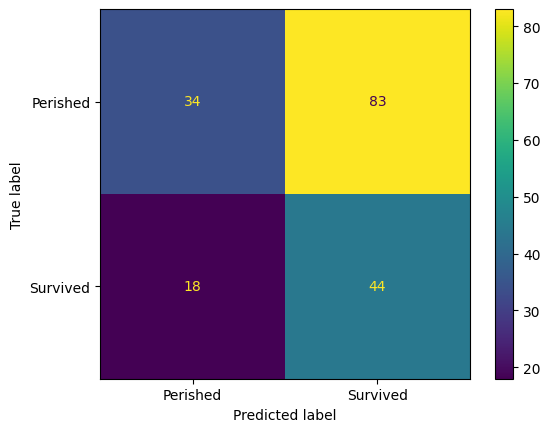

In [81]:
# 83 is false positive (false predicted to positive label, which has negative label as ground truth)
validator.display_confusion_matrix()

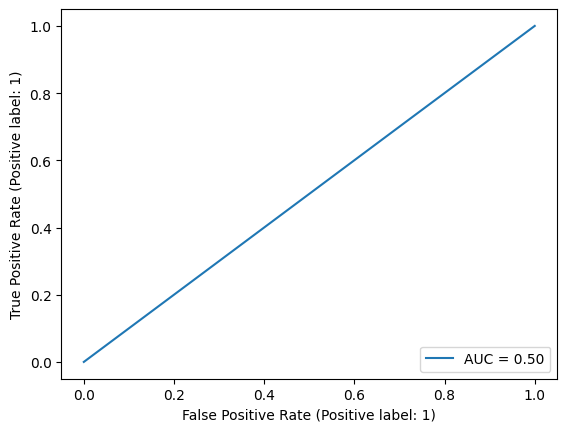

In [82]:
# ROC: Receiver operating characteristic
# AUC -> 1
validator.display_roc_curve()

## Model input feature attribution

In [83]:
# Create Explainer callable for X_valid data set
explainer = ModelExplainer(model=model, data=X_valid, dark_mode=DARK_MODE)


In [84]:
# explainer = ModelKernelExplainer(model=model, train_data=X_train, inference_data=X_valid, dark_mode=DARK_MODE)

In [85]:
@ModelExplainer.valid_index
def get_details(df: DataFrame, idx: int, org_df: DataFrame) -> DataFrame:
    """get the passenger info from the original data frame based on the index position of validation set
    @param df: 
    @param idx: index position, this must be idx so that decorator works
    """
    # get the index name from the original raw dataset, from the index position of validation data set
    index_name = df.iloc[idx].name
    # use slicing on the same index name to get the passenger info as a DataFrame obj
    return org_df.loc[index_name: index_name]

In [86]:
# examining the shap_values, as Explaination or List, Array from kernelExplainer
# explainer.shap_values

In [87]:
# shap.initjs()
# shap.plots.force(explainer.explainer.expected_value[1], 
#                  explainer.shap_values[1], explainer.data, link="identity")

In [88]:
# shap.plots.force(explainer.explainer.expected_value[1], explainer.shap_values[1][0], explainer.data.iloc[0], link="identity")

In [89]:
# shap.plots.force(explainer.explainer.expected_value[0], explainer.shap_values[0][0], explainer.data.iloc[0], link="identity")

     PassengerId  Pclass                  Name   Age  SibSp  Parch             Ticket   Fare Cabin Embarked  Sex_female  Sex_male
590          591       3  Rintamaki, Mr. Matti  35.0      0      0  STON/O 2. 3101273  7.125   NaN        S           0         1


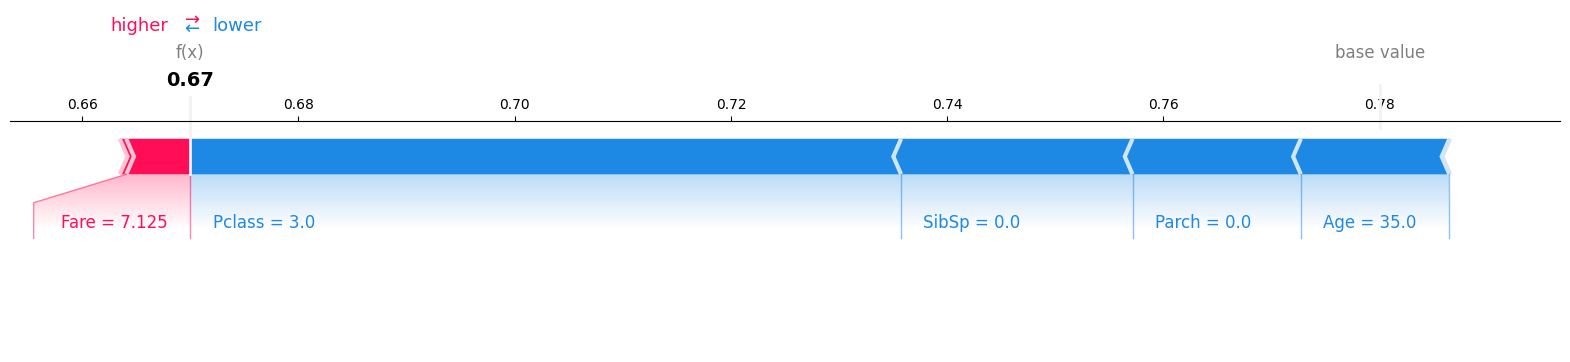

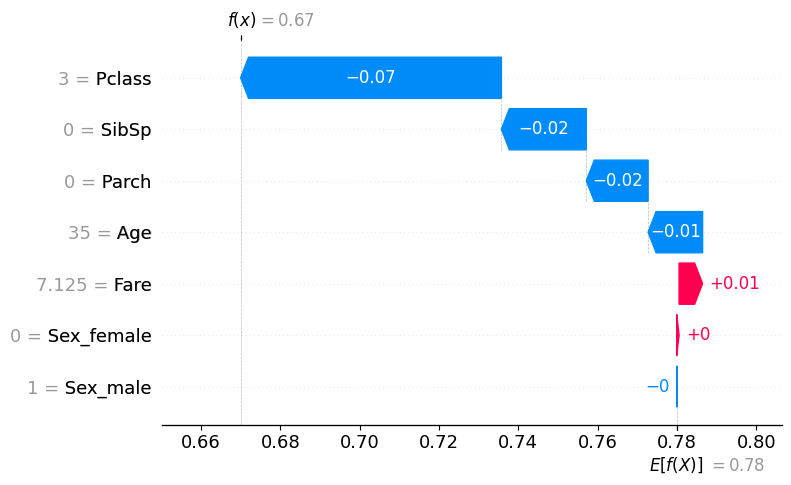

In [90]:
# Pclass = 3.0 doesn't play any rules for our passenger at X_valid dataset with rank pos 0
idx_pos = 0
passager_df = get_details(df=X_valid, idx=idx_pos, org_df = train_X_raw_df)
print(passager_df)
explainer.force_plot(idx = idx_pos)
explainer.waterfall_plot(idx = idx_pos)

     PassengerId  Pclass                        Name  Age  SibSp  Parch     Ticket    Fare Cabin Embarked  Sex_female  Sex_male
788          789       3  Dean, Master. Bertram Vere  1.0      1      2  C.A. 2315  20.575   NaN        S           0         1


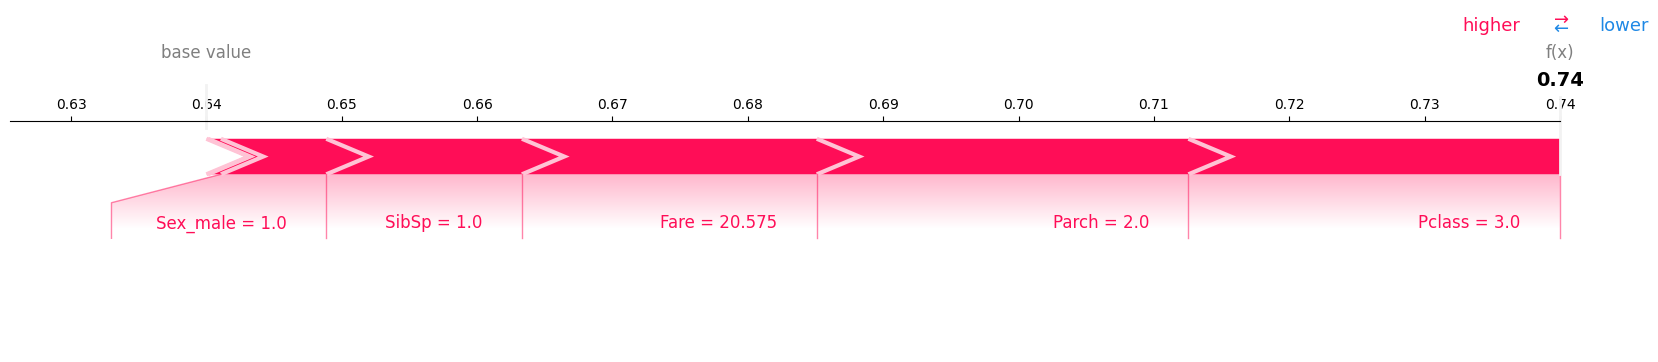

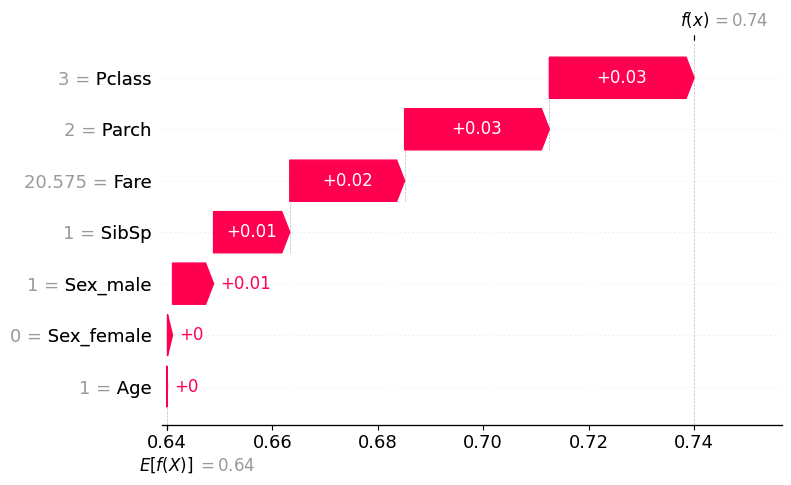

In [91]:
# Pclass = 3.0 doesn't play any rules for our passenger at X_valid dataset with rank pos 100
idx_pos = 100
passager_df = get_details(df=X_valid, idx=idx_pos, org_df = train_X_raw_df)
print(passager_df)
explainer.force_plot(idx = idx_pos)
explainer.waterfall_plot(idx = idx_pos)

In [92]:
# idx_pos = 178
# passager_df = get_details(df=X_valid, idx=idx_pos, org_df = train_X_raw_df)
# print(passager_df)
# explainer.force_plot(idx = idx_pos)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


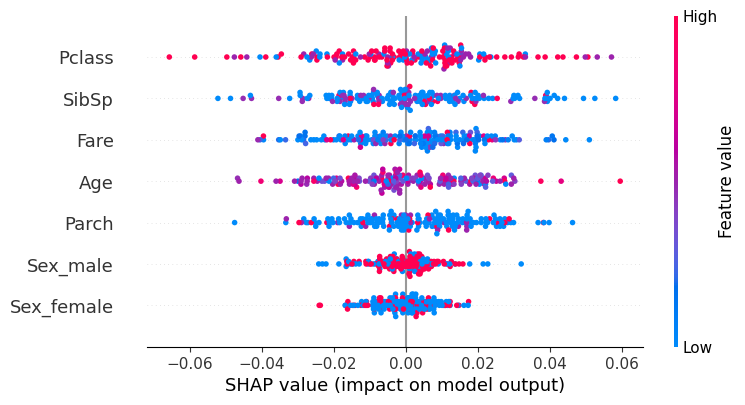

In [93]:
explainer.beeswarm_plot()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


black
viridis


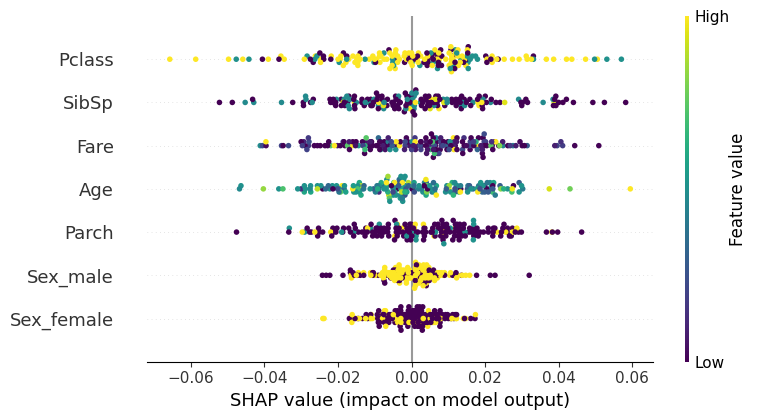

In [94]:
explainer.summary_plot()